## Previsão de Ordens Project

(Supervised Learning)

### 01. Data science project implementation
Our logistics department wants to improve our delivery system by smartly allocating delivery resources. 
As part of this effort, we would like to predict the number of order days in the month for each user, and 
we want to be able to perform this prediction at every point of the month.

The goal of the project is to create machining learning algorithms that, using the database we have so far, can continuously process and identify the number of days of orders.

To complete this project all the data was studied and maching learning models was created to do the predictions. <br />
All models was used using pyspark with Spark's MLlib. <br />
The data used are in the files:
1. ‘august_with_missing_order_days.parquet’, the already known orders for August with little missing data.
2. ‘historical_orders.parquet’, contains the historical transaction of the users and the file.
3. ‘august_total_sales.parquet’ contains the expected total value of the transaction in August for each user.
All the data is in parquet format and, after being received, has been processed for later use by ML.

In [1]:
# You may need to install the following libraries:
# pip install pandas numpy
# pip install matplotlib
# pip install seaborn
# pip install pyarrow
# pip install pyspark
# pip install sparkxgb
# pip install xgboost
# pip install scikit-learn

In [2]:
# Import related packages
from pathlib import Path
import pandas as pd
import numpy as np
import math
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# Feature Selection
from pyspark.ml.feature import VectorAssembler, StandardScaler
# from pyspark.ml.feature import StandardScaler as SparkStandardScaler

# Sklearn library
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler

# Build the Model
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from sparkxgb import XGBoostRegressor
import xgboost as xgb

# Directory
Path("temp").mkdir(parents=True, exist_ok=True)

# Start spark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('orders_days')\
    .master("local[*]")\
    .config("spark.jars.packages", "ml.dmlc:xgboost4j-spark_2.12:1.6.1") \
    .getOrCreate()

### 02. Sourcing Data

In [3]:
# 02.1 Loading data
dataset_01_missing_orders = spark.read.parquet('data/august_with_missing_order_days.parquet')

print("Total Rows:", dataset_01_missing_orders.count())
print("Total Columns:", len(dataset_01_missing_orders.columns))
print("Columns:", dataset_01_missing_orders.columns)
dataset_01_missing_orders.printSchema()
dataset_01_missing_orders.show(5)

Total Rows: 317735
Total Columns: 3
Columns: ['account_id', 'order_date', 'transaction_amount']
root
 |-- account_id: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- transaction_amount: double (nullable = true)

+--------------+----------+------------------+
|    account_id|order_date|transaction_amount|
+--------------+----------+------------------+
|BR_09532176632|2022-08-03|             11.16|
|BR_09532176632|2022-08-03|             32.52|
|BR_09532176632|2022-08-03|              24.9|
|BR_09532176632|2022-08-03|              28.5|
|BR_09532176632|2022-08-03|             11.16|
+--------------+----------+------------------+
only showing top 5 rows



In [4]:
dataset_02_historical_orders = spark.read.parquet('data/historical_orders.parquet')

print("Total Rows:", dataset_02_historical_orders.count())
print("Total Columns:", len(dataset_02_historical_orders.columns))
print("Columns:", dataset_02_historical_orders.columns)
dataset_02_historical_orders.printSchema()
dataset_02_historical_orders.show(5)

Total Rows: 8596877
Total Columns: 4
Columns: ['account_id', 'order_date', 'transaction_amount', '__index_level_0__']
root
 |-- account_id: string (nullable = true)
 |-- order_date: string (nullable = true)
 |-- transaction_amount: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)

+-----------------+----------+------------------+-----------------+
|       account_id|order_date|transaction_amount|__index_level_0__|
+-----------------+----------+------------------+-----------------+
|BR_09607801000194|2021-08-28|           11011.2|                0|
|BR_09607801000194|2021-08-28|           13764.0|                1|
|BR_09607801000194|2021-08-28|           11011.2|                2|
|BR_09607801000194|2021-08-28|           11011.2|                3|
|BR_09607801000194|2021-08-28|           13764.0|                4|
+-----------------+----------+------------------+-----------------+
only showing top 5 rows



In [5]:
dataset_03_august_tsales = spark.read.parquet('data/august_total_sales.parquet')

print("Total Rows:", dataset_03_august_tsales.count())
print("Total Columns:", len(dataset_03_august_tsales.columns))
print("Columns:", dataset_03_august_tsales.columns)
dataset_03_august_tsales.printSchema()
dataset_03_august_tsales.show(5)

Total Rows: 32944
Total Columns: 2
Columns: ['account_id', 'total_transaction_amount_august']
root
 |-- account_id: string (nullable = true)
 |-- total_transaction_amount_august: double (nullable = true)

+--------------+-------------------------------+
|    account_id|total_transaction_amount_august|
+--------------+-------------------------------+
|BR_00000343803|                         309.99|
|BR_00001415930|                         874.98|
|BR_00001760106|                        11976.7|
|BR_00002485176|                         511.48|
|BR_00002536340|                        7081.14|
+--------------+-------------------------------+
only showing top 5 rows



### 03. Exploratory Data Analysis and Data Cleaning

In [6]:
dataset_01_missing_orders.select("account_id").distinct().count() 
# Different Accounts R: 32944

dataset_01_missing_orders.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset_01_missing_orders.columns]).show()
# Null numbers in each column R: account_id: 0 ; order_date: 13438 ; transaction_amount: 13438

dataset_01_missing_orders.filter(dataset_01_missing_orders.order_date.isNull()).show(5)

+----------+----------+------------------+
|account_id|order_date|transaction_amount|
+----------+----------+------------------+
|         0|     13438|             13438|
+----------+----------+------------------+

+-----------------+----------+------------------+
|       account_id|order_date|transaction_amount|
+-----------------+----------+------------------+
|BR_66209644000100|      NULL|              NULL|
|   BR_04185749287|      NULL|              NULL|
|   BR_21110581220|      NULL|              NULL|
|BR_10296303000157|      NULL|              NULL|
|BR_06863137000156|      NULL|              NULL|
+-----------------+----------+------------------+
only showing top 5 rows



+-----------------+-----------+
|       account_id|orders_days|
+-----------------+-----------+
|   BR_01400607159|          5|
|BR_43167772000125|          4|
|   BR_54496128691|          1|
|BR_07527247000100|          3|
|   BR_02808482183|          3|
+-----------------+-----------+
only showing top 5 rows

+-----------+-----+
|orders_days|count|
+-----------+-----+
|          0|13438|
|          1| 8017|
|          2| 5125|
|          3| 3280|
|          4| 1637|
+-----------+-----+
only showing top 5 rows



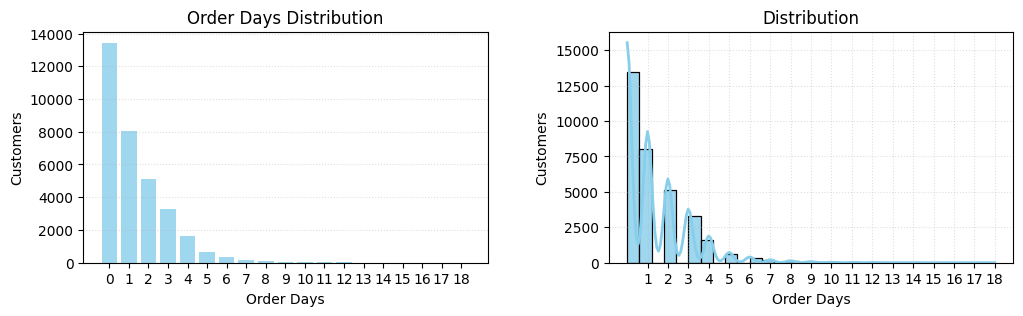

In [7]:
order_days_count_by_account = dataset_01_missing_orders.groupBy("account_id").agg(countDistinct("order_date").alias("orders_days"))
order_days_count_by_account.show(5) 

order_days_distribution = order_days_count_by_account.groupBy("orders_days").count().orderBy("orders_days")
order_days_distribution.show(5)

df_plot = order_days_distribution.toPandas()

fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)

ax0 = fig.add_subplot(gs[0, 0])
bars = ax0.bar(df_plot["orders_days"], df_plot["count"], color="skyblue", alpha=0.8)
ax0.set_title("Order Days Distribution")
ax0.set_xlabel("Order Days")
ax0.set_ylabel("Customers")
ax0.set_xticks(df_plot["orders_days"])
ax0.grid(axis="y", linestyle=":", alpha=0.4)

df_days = order_days_count_by_account.toPandas()

ax1 = fig.add_subplot(gs[0, 1])
sns.histplot(
    df_days["orders_days"], bins=30, kde=True, ax=ax1, color="skyblue", alpha=0.8, line_kws={"color": "black", "linewidth": 2})
ax1.set_title("Distribution")
ax1.set_xlabel("Order Days")
ax1.set_ylabel("Customers")
ax1.grid(True, linestyle=":", alpha=0.4)

max_day = int(df_plot["orders_days"].max())
ax1.set_xticks(range(1, max_day + 1))

plt.show()

**orders_days** (number of days with orders per customer in the month) shows an asymmetrical distribution to the right, as evidenced by the histogram and bar chart. This indicates that the majority of customers place few orders and only a minority place orders more frequently. <br />

(2a) Distribution: Poisson. Looking at the second graph, we can see some details for the values as integer numbers, non-negative, discrete (number of days, not a continuous measure), characteristic of a Poisson distribution.<br />

In [8]:
# (2b) Average Order Days (number of days with an order) per customer
lambda_poisson = df_days["orders_days"].mean()
print(f"Estimated Lambda: {lambda_poisson}")

# (2c) As an example, if we wanted to calculate the probability of having more than 4 Order Days.
p_more_than_4 = 1 - poisson.cdf(4, mu=lambda_poisson)
print(f"Probability of having more than 4 Order Days: {p_more_than_4:.2%}")

# (2d) Estimate the time between days of orders.
lambda_day = lambda_poisson / 30
avg_time = 1 / lambda_day
print(f"Average time between orders: {avg_time:.2f} days")

Estimated Lambda: 1.3333839242350656
Probability of having more than 4 Order Days: 1.18%
Average time between orders: 22.50 days


The parameter λ of the Poisson distribution was estimated as the average Order Days (number of days with an order) per customer

Poisson cumulative distribution function (CDF) 𝑃(𝑋>4)=1−𝑃(𝑋≤4)  <br />
P(X>4)≈1,18% , 1 out of 100 customers has more than 4 days with orders.

Orders follow a Poisson process over time, the interval between orders follows an Exponential distribution.<br />
Density function of the exponential distribution: f(t) = λe^(−λt)<br />
Calculation of the average time between orders:  average_time = 1/λ , λ is the rate of orders per day

+----------+------------------+
|order_date|distinct_customers|
+----------+------------------+
|2022-08-01|              3829|
|2022-08-02|              3985|
|2022-08-03|              3741|
|2022-08-04|              3424|
|2022-08-05|              2749|
+----------+------------------+
only showing top 5 rows



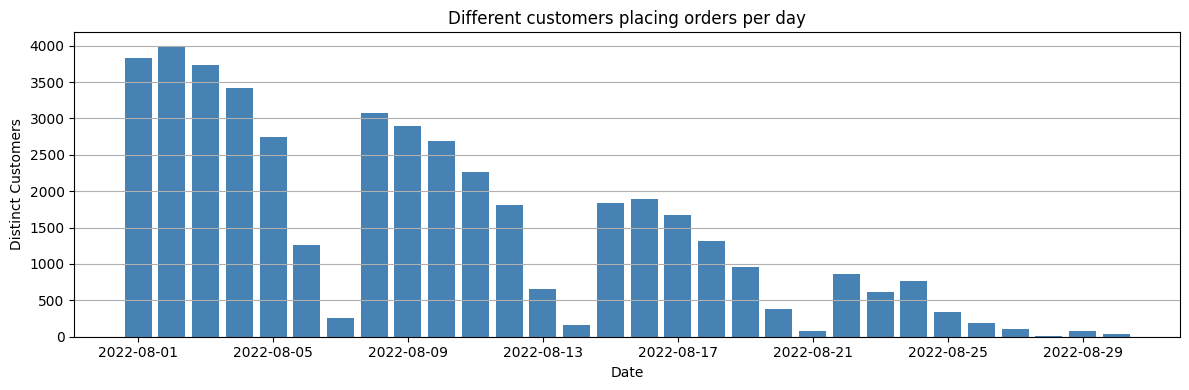

In [9]:
orders_per_day = dataset_01_missing_orders.filter(dataset_01_missing_orders.order_date.isNotNull()) \
    .groupBy("order_date") \
    .agg(countDistinct("account_id").alias("distinct_customers")) \
    .orderBy("order_date")
orders_per_day.show(5)

df_orders_per_day = orders_per_day.toPandas()
df_orders_per_day["order_date"] = pd.to_datetime(df_orders_per_day["order_date"])

plt.figure(figsize=(12, 4))
plt.bar(df_orders_per_day["order_date"], df_orders_per_day["distinct_customers"], color='steelblue')
plt.title("Different customers placing orders per day")
plt.xlabel("Date")
plt.ylabel("Distinct Customers")
# plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [10]:
dataset_01_missing_orders_clean = dataset_01_missing_orders \
    .filter(col("order_date").isNotNull() & col("transaction_amount").isNotNull()) \
    .withColumn("order_date", to_date("order_date")) # Cleaning: removing nulls from the August base

dataset_02_historical_orders_clean = dataset_02_historical_orders \
    .filter(col("order_date").isNotNull() & col("transaction_amount").isNotNull() & (col("transaction_amount") > 0)) \
    .withColumn("order_date", to_date("order_date")) # Historical base cleaning; Filtering returns, canceled orders, etc.

In [11]:
numeric_cols = [c for c, t in dataset_02_historical_orders_clean.dtypes if t in ['double', 'float']]
string_cols = [c for c in dataset_02_historical_orders_clean.columns if c not in numeric_cols]

dataset_02_historical_orders_clean.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in numeric_cols
]).show() # double check nulls in numeric, clean data

dataset_02_historical_orders_clean.select([
    count(when(col(c).isNull(), c)).alias(c) for c in string_cols
]).show() # double check nulls in other columns, clean data

# Contagens adicionais
print("Distinct Accounts:", dataset_02_historical_orders_clean.select("account_id").distinct().count())
print("Transactions <= 0:", dataset_02_historical_orders_clean.filter(col("transaction_amount") <= 0).count())

+------------------+
|transaction_amount|
+------------------+
|                 0|
+------------------+

+----------+----------+-----------------+
|account_id|order_date|__index_level_0__|
+----------+----------+-----------------+
|         0|         0|                0|
+----------+----------+-----------------+

Distinct Accounts: 47756
Transactions <= 0: 0


In [12]:
dataset_02_historical_monthly = dataset_02_historical_orders_clean \
    .withColumn("year", year("order_date")) \
    .withColumn("month", month("order_date")) \
    .groupBy("account_id", "year", "month") \
    .agg(countDistinct("order_date").alias("order_days"), 
         sum("transaction_amount").alias("total_sales"))
dataset_02_historical_monthly.show(5)

# Statistics by client (Window):
window_acc = Window.partitionBy("account_id")

dataset_02_historical_stats = dataset_02_historical_monthly \
    .withColumn("avg_order_days", avg("order_days").over(window_acc)) \
    .withColumn("std_order_days", stddev("order_days").over(window_acc)) \
    .withColumn("avg_total_sales", avg("total_sales").over(window_acc)) \
    .withColumn("std_total_sales", stddev("total_sales").over(window_acc)) \
    .withColumn("n_months", count("month").over(window_acc))

dataset_02_historical_stats_dedup = dataset_02_historical_stats \
    .select("account_id", "avg_order_days", "std_order_days", "avg_total_sales", "std_total_sales", "n_months") \
    .dropDuplicates(["account_id"]) # removing duplicates
dataset_02_historical_stats_dedup.show(5)

+-----------------+----+-----+----------+------------------+
|       account_id|year|month|order_days|       total_sales|
+-----------------+----+-----+----------+------------------+
|   BR_04138378740|2022|    4|         3|           5687.12|
|   BR_75080869968|2021|    6|         1|360.91999999999996|
|BR_36979617000148|2021|   11|         2|13633.609999999997|
|   BR_84543329015|2021|   10|         6|           56507.4|
|   BR_60253401020|2021|   10|         2| 732.8199999999999|
+-----------------+----+-----+----------+------------------+
only showing top 5 rows

+-----------------+------------------+------------------+------------------+------------------+--------+
|       account_id|    avg_order_days|    std_order_days|   avg_total_sales|   std_total_sales|n_months|
+-----------------+------------------+------------------+------------------+------------------+--------+
|   BR_00005396352|5.7368421052631575|  2.20711237349614|17746.192631578946|7111.7983827430835|      19|
|BR_00

In [13]:
df_stats = dataset_02_historical_stats_dedup.toPandas()

X = df_stats[["avg_order_days", "avg_total_sales"]] # Numeric features

scaler_sklearn = SklearnStandardScaler()
X_scaled = scaler_sklearn.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
df_stats["cluster"] = kmeans.fit_predict(X_scaled)

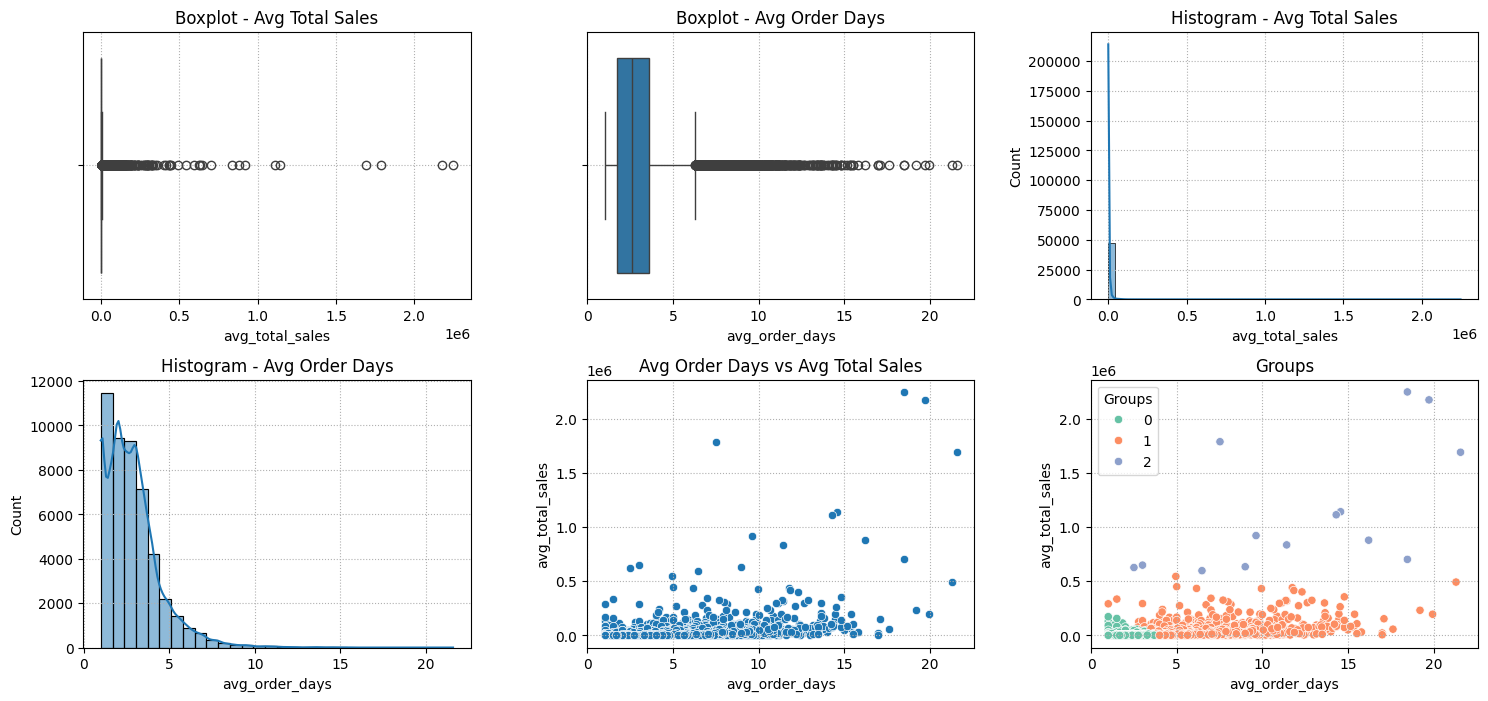

avg_order_days                                                 \
                 count       mean       std  min       25%        50%   
cluster                                                                 
0              37112.0   2.214686  0.819661  1.0  1.500000   2.181818   
1              10630.0   5.161662  1.586351  1.0  4.052632   4.666667   
2                 14.0  12.350967  6.202728  2.5  7.894737  12.868421   

                              avg_total_sales                ...  \
               75%        max           count          mean  ...   
cluster                                                      ...   
0         2.947368   3.764706         37112.0  1.670147e+03  ...   
1         5.714286  21.315789         10630.0  1.196728e+04  ...   
2        17.907895  21.578947            14.0  1.142363e+06  ...   

                                    n_months                                  \
                  75%           max    count       mean       std  min   25%   
cluster                                                                        
0        1.766988e+03  1.730509e+05  37112.0   7.559469  5.765585  1.0   3.0   
1        1.101272e+04  5.444922e+05  10630.0  12.631703  6.324236  1.0   6.0   
2        1.552749e+06  2.246461e+06     14.0  14.857143  6.915503  1.0  10.0   

                           
          50%   75%   max  
cluster                    
0         6.0  11.0  19.0  
1        15.0  19.0  19.0  
2        19.0  19.0  19.0  

[3 rows x 24 columns]

In [14]:
fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(2, 3, wspace=0.3, hspace=0.3)

# Boxplot - Avg Total Sales
ax0 = fig.add_subplot(gs[0, 0])
sns.boxplot(x=df_stats["avg_total_sales"], ax=ax0)
ax0.set_title("Boxplot - Avg Total Sales")
ax0.grid(True, linestyle=':')

# Boxplot - Avg Order Days
ax1 = fig.add_subplot(gs[0, 1])
sns.boxplot(x=df_stats["avg_order_days"], ax=ax1)
ax1.set_title("Boxplot - Avg Order Days")
ax1.grid(True, linestyle=':')

# Histogram - Avg Total Sales
ax2 = fig.add_subplot(gs[0, 2])
sns.histplot(df_stats["avg_total_sales"], bins=50, kde=True, ax=ax2)
ax2.set_title("Histogram - Avg Total Sales")
ax2.grid(True, linestyle=':')

# Histogram - Avg Order Days
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(df_stats["avg_order_days"], bins=30, kde=True, ax=ax3)
ax3.set_title("Histogram - Avg Order Days")
ax3.grid(True, linestyle=':')

# Scatterplot - Avg Order Days vs Avg Total Sales
ax4 = fig.add_subplot(gs[1, 1])
sns.scatterplot(data=df_stats, x="avg_order_days", y="avg_total_sales", ax=ax4)
ax4.set_title("Avg Order Days vs Avg Total Sales")
ax4.grid(True, linestyle=':')

# Scatterplot com clusters
ax5 = fig.add_subplot(gs[1, 2])
sns.scatterplot(data=df_stats, x="avg_order_days", y="avg_total_sales", hue="cluster", palette="Set2", ax=ax5)
ax5.set_title("Groups")
ax5.grid(True, linestyle=':')
ax5.legend(title="Groups")

plt.show()
df_stats.groupby("cluster")[["avg_order_days", "avg_total_sales", "n_months"]].describe()

### 04. Modeling and Evaluation

In [15]:
training_data = dataset_02_historical_stats.filter(~((col("year") == 2022) & (col("month") == 8))).fillna(0)

feature_cols = ["total_sales", "avg_order_days", "std_order_days", 
                "avg_total_sales", "std_total_sales", "n_months"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_train = assembler.transform(training_data).select("features", "order_days")

# Scale and Normalizing 
data_train_scaled = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True) \
    .fit(data_train).transform(data_train).select("scaled_features", "order_days")

# Dividing the sample
train_data, test_data = data_train_scaled.randomSplit([0.8, 0.2], seed=42)

In [16]:
# Linear Regression
model_lr = LinearRegression(featuresCol="scaled_features", labelCol="order_days")
model_lr_fitted = model_lr.fit(train_data)
pred_lr = model_lr_fitted.transform(test_data)

# Random Forest
model_rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="order_days", numTrees=100)
model_rf_fitted = model_rf.fit(train_data)
pred_rf = model_rf_fitted.transform(test_data)

# XGBoost
model_xgb_spark = XGBoostRegressor(featuresCol="scaled_features", labelCol="order_days", objective='reg:squarederror')
model_xgb_spark_fitted = model_xgb_spark.fit(train_data)
pred_xgb_spark = model_xgb_spark_fitted.transform(test_data)

# Evaluation
evaluator = RegressionEvaluator(labelCol="order_days", predictionCol="prediction")

print("[LR] RMSE:", evaluator.setMetricName("rmse").evaluate(pred_lr))
print("[LR] MAE:", evaluator.setMetricName("mae").evaluate(pred_lr))
print("[LR] R2 :", evaluator.setMetricName("r2").evaluate(pred_lr))
print("[RF] RMSE:", evaluator.setMetricName("rmse").evaluate(pred_rf))
print("[RF] MAE:", evaluator.setMetricName("mae").evaluate(pred_rf))
print("[RF] R2 :", evaluator.setMetricName("r2").evaluate(pred_rf))
print("[XGB Spark] RMSE:", evaluator.setMetricName("rmse").evaluate(pred_xgb_spark))
print("[XGB Spark] MAE:", evaluator.setMetricName("mae").evaluate(pred_xgb_spark))
print("[XGB Spark] R2 :", evaluator.setMetricName("r2").evaluate(pred_xgb_spark))

[LR] RMSE: 1.33915918678777
[LR] MAE: 0.9762439592182788
[LR] R2 : 0.6317463515091442
[RF] RMSE: 1.2488898415127123
[RF] MAE: 0.9096177042054118
[RF] R2 : 0.6797191927006179
[XGB Spark] RMSE: 2.685779967076107
[XGB Spark] MAE: 2.033163170827881
[XGB Spark] R2 : -0.481233442274392


[XGB] RMSE: 0.9566858096372908
[XGB] MAE: 0.6650993824005127
[XGB Sklearn] R2 : 0.8120590448379517


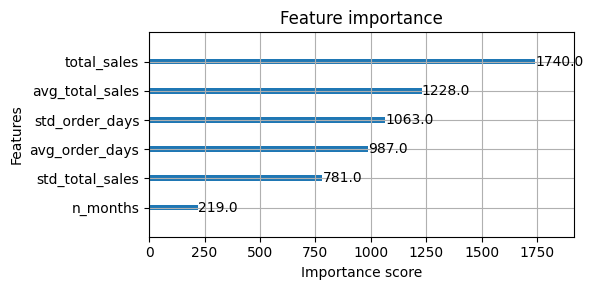

In [17]:
train_pd = train_data.toPandas()
test_pd = test_data.toPandas()

feature_names = assembler.getInputCols()

# Extrair features e target
X_train = pd.DataFrame(np.vstack(train_pd['scaled_features']), columns=feature_names)
y_train = train_pd['order_days']
X_test = pd.DataFrame(np.vstack(test_pd['scaled_features']), columns=feature_names)
y_test = test_pd['order_days']

# XGBoost
model_xgb_pd = xgb.XGBRegressor(objective='reg:squarederror')
model_xgb_pd.fit(X_train, y_train)
pred_xgb_pd = model_xgb_pd.predict(X_test)

# Evaluation
print("[XGB] RMSE:", np.sqrt(mean_squared_error(y_test, pred_xgb_pd)))
print("[XGB] MAE:", mean_absolute_error(y_test, pred_xgb_pd))
print("[XGB Sklearn] R2 :", r2_score(y_test, pred_xgb_pd))

fig, ax = plt.subplots(figsize=(6, 3))  
xgb.plot_importance(model_xgb_pd, ax=ax)
plt.tight_layout()
plt.show()

### Which model is better

- XGBoost results different between PySpark and Pandas

sparkxgb.XGBoostRegressor uses XGBoost4J, which is a Java/Scala implementation integrated with Spark.<br/>
xgboost.XGBRegressor uses the official Python API, which is more mature, widely tested, and feature-rich. The Python version is usually more accurate and reliable, especially in smaller datasets, since it gives you finer control over parameters and data handling.

Based on the results:<br/>
Model: RMSE | MAE<br/>
1º XGBoost (Pandas): 0.96 | 0.66 <br/>
2º RandomForest: 1.25 | 0.91<br/>
3º LinearRegression: 1.34 | 0.98<br/>
4º XGBoost (SparkXGB): 2.68 | 2.03 


In [18]:
# August prediction with final model
dataset_03_august_tsales_agg = dataset_03_august_tsales.groupBy("account_id") \
    .agg(sum("total_transaction_amount_august").alias("total_sales"))

order_days_so_far = dataset_01_missing_orders_clean.select("account_id", "order_date").distinct() \
    .groupBy("account_id").agg(countDistinct("order_date").alias("days_with_orders_so_far")).fillna(0)

dataset_august_features_full = dataset_03_august_tsales_agg \
    .join(dataset_02_historical_stats_dedup, on="account_id", how="left").fillna(0)

dataset_august_missing_hist = dataset_03_august_tsales_agg.join(dataset_02_historical_stats_dedup, on="account_id", how="left_anti")
dataset_august_missing_hist.count() # R: 1248, August accounts with no history

assembler_august = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_august = assembler_august.transform(dataset_august_features_full)
data_august_scaled = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True) \
    .fit(data_august).transform(data_august)

data_august_pd = data_august_scaled.select("account_id", "scaled_features").toPandas() # Convert to Pandas for XGBoost prediction
X_august = np.vstack(data_august_pd['scaled_features'])

pred_august_xgb = model_xgb_pd.predict(X_august)
data_august_pd['predicted_order_days'] = pred_august_xgb
data_august_pd.head()

,account_id,scaled_features,predicted_order_days
0,BR_00005396352,"[0.37411682043967737, 1.4944765260655237, 1.47...",6.555042
1,BR_00012291000138,"[-0.15681696284583949, -0.47072116342873216, -...",1.128465
2,BR_00016559738,"[-0.14523336412481663, 0.24850067138617596, -0...",1.829174
3,BR_00032276427,"[-0.12757988987040914, 0.03577308644092153, -0...",3.290334
4,BR_00065365577,"[0.08555468467109183, 1.403307561088986, 0.738...",6.893760


In [19]:
# Temporary processing step
data_august_pd[["account_id", "predicted_order_days"]].to_parquet("temp/predictions_august.parquet", index=False)
august_pred_spark = spark.read.parquet("temp/predictions_august.parquet")

In [20]:
final_prediction = august_pred_spark \
    .join(order_days_so_far, on="account_id", how="left") \
    .fillna(0, subset=["days_with_orders_so_far"]) \
    .withColumn("predicted_order_days_remaining", (ceil(col("predicted_order_days")) - col("days_with_orders_so_far")).cast("int"))

final_prediction.select(
    "account_id", 
    "predicted_order_days", 
    "days_with_orders_so_far", 
    "predicted_order_days_remaining"
).show(5)

print("Total rows:", final_prediction.count())
print("Unique accounts:", final_prediction.select("account_id").distinct().count())

+-----------------+--------------------+-----------------------+------------------------------+
|       account_id|predicted_order_days|days_with_orders_so_far|predicted_order_days_remaining|
+-----------------+--------------------+-----------------------+------------------------------+
|   BR_00005396352|           6.5550423|                      0|                             7|
|BR_00012291000138|           1.1284652|                      0|                             2|
|   BR_00016559738|           1.8291743|                      2|                             0|
|   BR_00032276427|           3.2903342|                      2|                             2|
|   BR_00065365577|             6.89376|                      1|                             6|
+-----------------+--------------------+-----------------------+------------------------------+
only showing top 5 rows

Total rows: 32944
Unique accounts: 32944


In [21]:
# Exporting the final result
data_final = final_prediction.select(
    col("account_id"),
    col("predicted_order_days_remaining").alias("prediction"))
data_final_pd = data_final.toPandas()

data_final_pd.to_csv("order_days_prediction.csv", index=False, header=True)

### 05. Discussion and Conclusion
According to the model results, the algorithm that obtained the best result compared to the other algorithms was XGBoost using python API. <br/>
We can see that the model is not perfect (“perfect” does not exist) and we can work on some points to obtain better results, adding clusters as features, creating temporal features (last months), treating outliers better, but I understand that the result was good and the model works.<br/>

Thanks for following along here and if you have any suggestions or comments, I'm 100% open!

**Joao Ambrosio**